# Chi Analysis with Resampling


---
**License**

Chi Analysis with Resampling

 Fri Mar 14 08:50:00 2025\
 Copyright  2025\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Chi_Analysis_Resample \
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages & Configs

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

#Useful packages
import numpy as np
import math
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# GCRCatalogs
sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

#Calibration functions
from bdata import DataB
from model_fitting import ModelFitting

## Data

### Data matched by ID

In [2]:
test_matchdata = Table.read('CatalogsMatching/match_ID.fits')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift"]
mass_data = test_matchdata["halo_mass"]
r_err_data = test_matchdata["richness_err"]

test_dt = Table([mass_data, rich_data, z_data, r_err_data], names=('mass', 'richness', 'redshift', 'richness_err'))


### NumCosmo's Matching By Proximity

In [3]:
# mdata = Table.read('CatalogsMatching/match_proximity.fits')

# rich_data = mdata["R"]
# z_data = mdata["z"]
# mass_data = mdata["mass"]

# test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

### Data threshold

In [4]:
test_dt = test_dt[test_dt['mass'] > 1e13]
test_dt = test_dt[np.logical_and(test_dt['redshift'] > 0, test_dt['redshift']< 3)]
test_dt = test_dt[np.logical_and(test_dt['richness'] > 0, test_dt['richness'] < 1e10)]

mass_dt = test_dt['mass']
red_dt = test_dt['redshift']
rich_dt = test_dt['richness']

print('Data')
print('\t\tMax \t\t\tMin')
print(f'Mass:\t\t{max(mass_dt):.2e}, \t\t{min(mass_dt):.2e}')
print(f'Redshift:\t{max(red_dt)}, \t{min(red_dt)}')
print(f'Richness:\t{max(rich_dt)}, \t{min(rich_dt)}')


Data
		Max 			Min
Mass:		1.90e+15, 		1.00e+13
Redshift:	1.1998511783121595, 	0.07887901955195975
Richness:	266.2950439453125, 	5.007844924926758


## Models fitting

In [5]:
fm = ModelFitting(test_dt) #Fit object

In [6]:
area = 439.78987
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 71.0)
cosmo.param_set_by_name("Omegab", 0.0448)
cosmo.param_set_by_name("Omegac", 0.2648)
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0)

cluster_z = Nc.ClusterRedshiftNodist (z_min = 0, z_max = 1.2)

### Ascaso Fit Params

In [7]:
ascaso, fit_ascaso, dmr_asc = fm.run_fit('ascaso')

lnR_mean_ascaso = fm.get_mean_model(ascaso, np.log(test_dt['mass']),  test_dt['redshift'])
lnR_std_ascaso = fm.get_std_model(ascaso, np.log(test_dt['mass']), test_dt['redshift'])

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

In [8]:
mset_asc = Ncm.MSet.new_array([cosmo, ascaso, cluster_z])
mset_asc.prepare_fparam_map()

rng = Ncm.RNG.seeded_new(None, 40)
dmr_asc.resample(mset_asc, rng)

dset_asc = Ncm.Dataset.new()
dset_asc.append_data(dmr_asc)
    
lh_asc = Ncm.Likelihood.new(dset_asc)

ascaso.param_set_by_name("cut", np.log(5))
mset_asc["NcClusterMass"].param_set_desc('cut', {"fit": False})
    
mset_asc.prepare_fparam_map()
    
fit_asc = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh_asc, mset_asc, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit_asc.log_info()
fit_asc.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit_asc.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -      H0[00]:  71                  [FIXED]
#   -  Omegac[01]:  0.2648              [FIXED]
#   -  Omegak[02]:  0                   [FIXED]
#   - Tgamma0[03]:  2.7245              [FIXED]
#   -      Yp[04]:  0.24                [FIXED]
#   -    ENnu[05]:  3.046               [FIXED]
#   -  Omegab[06]:  0.0448              [FIXED]
#   -       w[07]: -1                   [FIXED]
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Mod

In [9]:
lnR_mean_ascaso_r = fm.get_mean_model(ascaso, np.log(test_dt['mass']),  test_dt['redshift'])
lnR_std_ascaso_r = fm.get_std_model(ascaso, np.log(test_dt['mass']), test_dt['redshift'])

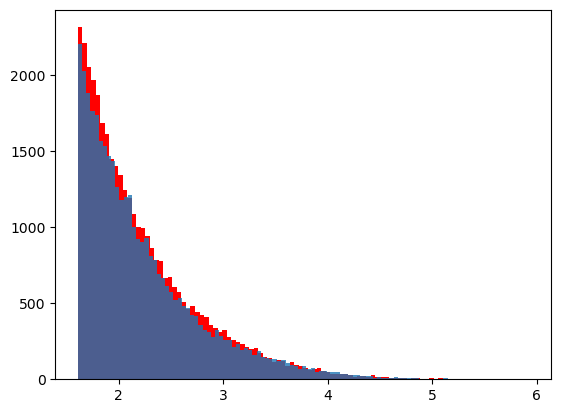

In [10]:
plt.hist(dmr_asc.props.lnR_cluster.dup_array(), bins = 100, color = 'r')
plt.hist(np.log(rich_data), bins = 100, alpha = 0.8)

plt.show()

### Ext (ln(1+z)) Fit Params

In [ ]:
ext_ln1pz, fit_ext, dmr_ext = fm.run_fit('ext_ln1pz')

lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  np.log(test_dt['mass']), test_dt['redshift'])
lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz,  np.log(test_dt['mass']), test_dt['redshift'])

In [ ]:
mset_ext = Ncm.MSet.new_array([cosmo, ext_ln1pz, cluster_z])
mset_ext.prepare_fparam_map()

rng = Ncm.RNG.seeded_new(None, 40)
dmr_ext.resample(mset_ext, rng)

dset_ext = Ncm.Dataset.new()
dset_ext.append_data(dmr_ext)
    
#Likelihood
lh_ext = Ncm.Likelihood.new(dset_ext)

ext_ln1pz.param_set_by_name("cut", np.log(5))
mset_ext["NcClusterMass"].param_set_desc('cut', {"fit": False})
    
mset_ext.prepare_fparam_map()
    
#Fit
fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh_ext, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL )
fit.log_info()
fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
fit.log_info()

In [ ]:
lnR_mean_ext_ln1pz_r = fm2.get_mean_model(ext_ln1pz_r,  np.log(test_dt_resampled['mass']), test_dt_resampled['redshift'])
lnR_std_ext_ln1pz_r = fm2.get_std_model(ext_ln1pz_r,  np.log(test_dt_resampled['mass']), test_dt_resampled['redshift'])

In [ ]:
plt.hist(dmr_ext.props.lnR_cluster.dup_array(), bins = 100, color = 'r')
plt.hist(np.log(rich_data), bins = 100, alpha = 0.8)

plt.show()

## Errors

In [25]:
# residuals_ext = (np.log(rich_dt) - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz
residuals_asc = (np.log(rich_dt) - lnR_mean_ascaso) / lnR_std_ascaso

# residuals_ext_r = (np.log(rich_dt) - lnR_mean_ext_ln1pz) / lnR_std_ext_ln1pz
residuals_asc_r = (dmr_asc.props.lnR_cluster.dup_array() - lnR_mean_ascaso_r) / lnR_std_ascaso_r

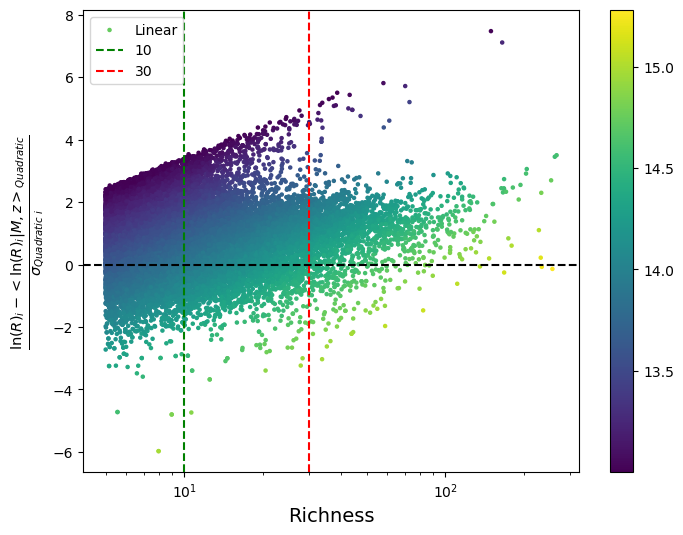

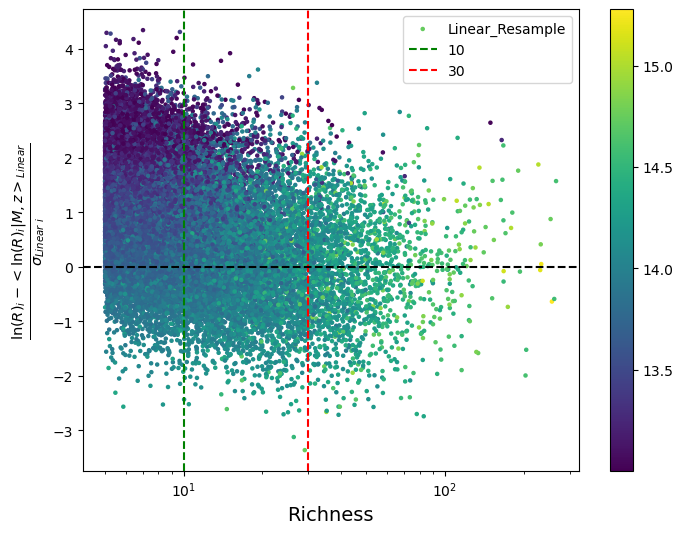

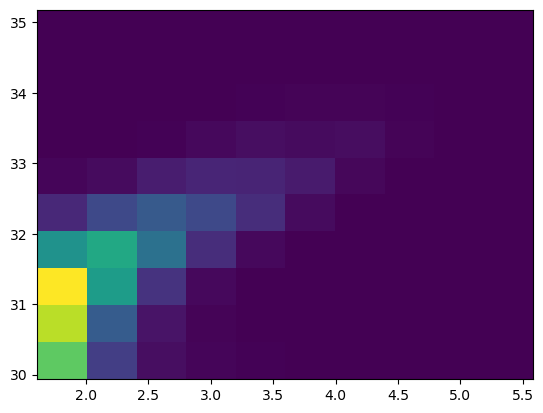

In [29]:
plt.figure(figsize=(8,6))

p2 = plt.scatter(rich_dt, residuals_asc, c= np.log10(mass_dt), s=5.0, label = 'Linear')

plt.colorbar(p2)

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Quadratic} }{\sigma_{Quadratic \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

plt.figure(figsize=(8,6))

p1 = plt.scatter(rich_dt, residuals_asc_r, c= np.log10(mass_dt), s=5.0, label = 'Linear_Resample')

plt.colorbar(p1)

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

plt.hist2d(np.log(rich_dt), np.log(mass_dt))
plt.show()


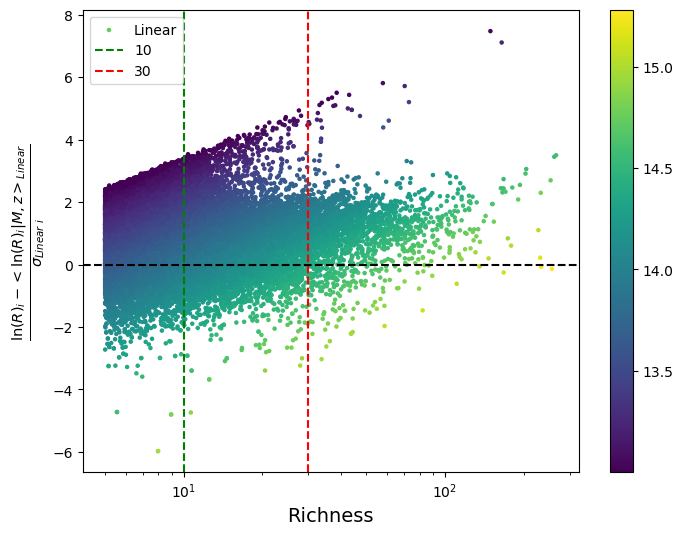

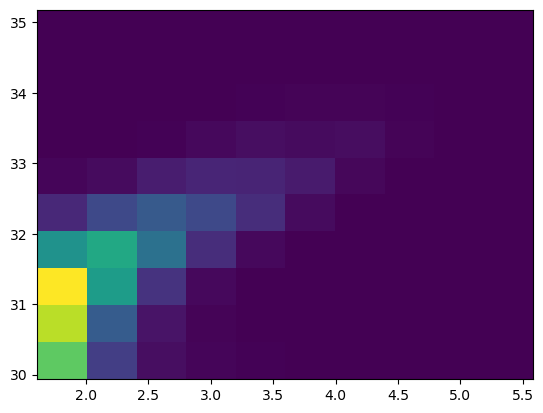

In [23]:
plt.figure(figsize=(8,6))

# p2 = plt.scatter(test_dt_resampled['richness'], residuals_ext_r, c= np.log10(test_dt_resampled['mass']), s=5.0, label = 'Quadratic')

# plt.colorbar(p2)

# plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Quadratic} }{\sigma_{Quadratic \ i}}$', fontsize=15)
# plt.axvline(x=10, color='g', ls='--', label='10')
# plt.axvline(x=30, color='r', ls='--', label='30')
# plt.axhline(y=0.0, color='k', ls='--')


# plt.xscale('log')
# plt.legend()
# plt.xlabel('Richness', fontsize=14)

# plt.show()

# plt.figure(figsize=(8,6))

p1 = plt.scatter(test_dt['richness'], residuals_asc, c= np.log10(test_dt['mass']), s=5.0, label = 'Linear')

plt.colorbar(p1)

plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=10, color='g', ls='--', label='10')
plt.axvline(x=30, color='r', ls='--', label='30')
plt.axhline(y=0.0, color='k', ls='--')


plt.xscale('log')
plt.legend()
plt.xlabel('Richness', fontsize=14)

plt.show()

plt.hist2d(np.log(rich_dt), np.log(mass_dt))
plt.show()


In [20]:
# plt.figure(figsize=(8,6))

# plt.scatter(rich_dt, residuals_asc, s=5.0, label = 'Linear')
# plt.scatter(rich_dt, residuals_ext, s=5.0, label = 'Quadratic')

# plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Quadratic} }{\sigma_{Quadratic \ i}}$', fontsize=15)
# plt.axvline(x=10, color='g', ls='--', label='10')
# plt.axvline(x=30, color='r', ls='--', label='30')
# plt.axhline(y=0.0, color='k', ls='--')


# plt.xscale('log')
# plt.legend()
# plt.xlabel('Richness', fontsize=14)

# plt.show()

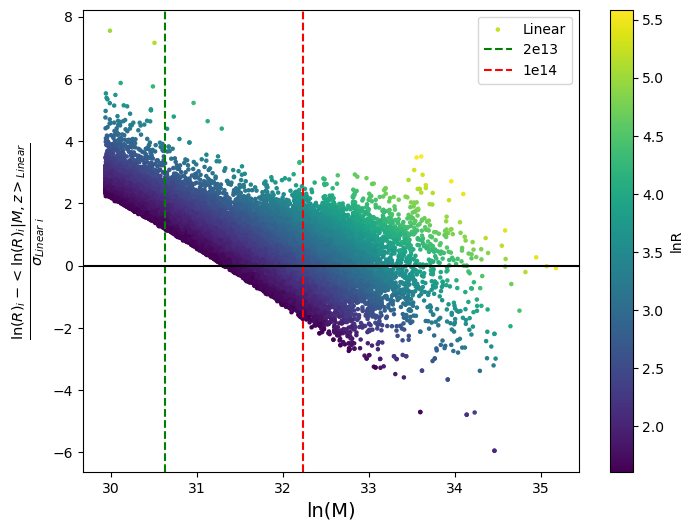

In [21]:
plt.figure(figsize=(8,6))

p3 = plt.scatter(np.log(test_dt['mass']), residuals_asc_r, c = np.log(test_dt['richness']),  s=5.0, label = 'Linear')
plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
plt.axhline(y=0.0, color='k', ls='-')

plt.colorbar(p3, label = 'lnR')

plt.legend()
plt.xlabel('ln(M)', fontsize=14)


plt.show()

# plt.figure(figsize=(8,6))
# p4=plt.scatter(np.log(test_dt_resampled['mass']), residuals_ext_r, c = np.log(test_dt_resampled['richness']),  s=5.0, label = 'Quadratic')
# plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
# plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
# plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
# plt.axhline(y=0.0, color='k', ls='-')

# plt.colorbar(p4, label='ln(R)')

# plt.legend()
# plt.xlabel('ln(M)', fontsize=14)


# plt.show()

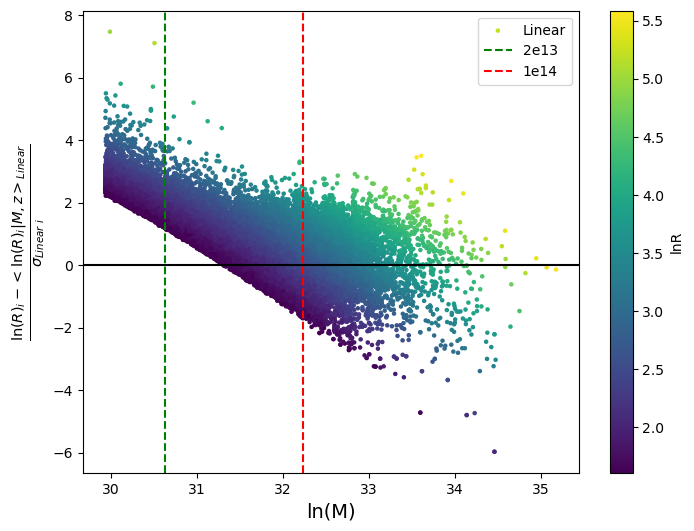

NameError: name 'residuals_ext' is not defined

<Figure size 800x600 with 0 Axes>

In [13]:
plt.figure(figsize=(8,6))

p3 = plt.scatter(np.log(mass_dt), residuals_asc, c = np.log(rich_dt),  s=5.0, label = 'Linear')
plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
plt.axhline(y=0.0, color='k', ls='-')

plt.colorbar(p3, label = 'lnR')

plt.legend()
plt.xlabel('ln(M)', fontsize=14)


plt.show()

plt.figure(figsize=(8,6))
p4=plt.scatter(np.log(mass_dt), residuals_ext, c = np.log(rich_dt),  s=5.0, label = 'Quadratic')
plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
plt.axvline(x=np.log(2e13), color='g', ls='--', label='2e13')
plt.axvline(x=np.log(1e14), color='r', ls='--', label='1e14')
plt.axhline(y=0.0, color='k', ls='-')

plt.colorbar(p4, label='ln(R)')

plt.legend()
plt.xlabel('ln(M)', fontsize=14)


plt.show()

In [ ]:
# plt.scatter(np.log(mass_dt), residuals_ext, s=3.0)
# plt.ylabel(r'$\frac{\ln(R)_{i}  - < \ln(R)_{i} | M, z >_{Linear} }{\sigma_{Linear \ i}}$', fontsize=15)
# # plt.yscale('log')
# plt.xlabel('ln(M)', fontsize=14)
# plt.show()



In [ ]:

# plt.hist( test_dt_resampled["richness"] , bins=100)
# plt.show()

In [ ]:
# plt.scatter(np.log(mass_dt), residuals_ext - residuals_asc, s=3.0)
# plt.ylabel(r'$\chi_{Quad} - \chi_{Linear}$', fontsize=15)
# plt.xlabel('ln(M)', fontsize=14)
# # plt.yscale('log')
# plt.show()